# Visualise Extracted Shapelets

This script must be run from the same directory as the scripts which it imports.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pyts.transformation import ShapeletTransform

np.random.seed(12345)

%run sys_configs.ipynb

In [2]:
with open('data/train.npy', 'rb') as f:
    x_train = np.load(f)
    y_train = np.load(f)
sz, dim = x_train.shape[1:]

classes = np.unique(y_train)  

N_train = len(y_train)

Select a sample of 200 time series for a single component.

In [3]:
sample_size = 200

# Choose the secondary sample indexes
random_idxs = np.random.choice(N_train, size = sample_size, replace=False)

# Obtain each of the 6 components of the sensor data
train_acc_x = x_train[random_idxs, :, 0]

# Obtain the corresponding class labels from the indexes
y_train = y_train[random_idxs]

Fit the Shapelet Transform. Preserve the 10 best shapelets and use a window size of 20 so the shapelets are easy to inspect.

In [4]:
# Initialise, then fit, the Shapelet transform.
st_acc_x = ShapeletTransform(n_shapelets = 10, window_sizes=[20], criterion = "anova", remove_similar = True, sort = True)

In [5]:
acc_x_shapelets = st_acc_x.fit(train_acc_x, y_train)

Get the index of the sample which contained the most discriminative (i.e. best) shapelet and the start and end time steps of the shapelet. Then save the shapelet to a Numpy array in its own right.

In [6]:
idx, start, end = st_acc_x.indices_[0]
shapelet = train_acc_x[idx, start:end]

Get the best shapelet's activity label. Then select a sample at random. The sample should not be the same sample from which the shapelet was extracted. This script should use Numpy seeding to guarantee this.

In [7]:
best_label = y_train[idx]

same_activity_samples = train_acc_x[y_train == best_label]
diff_activity_samples = train_acc_x[y_train != best_label]

random_idx_same_activity = np.random.choice(len(same_activity_samples), size = 1)[0]
random_idx_diff_activity = np.random.choice(len(diff_activity_samples), size = 1)[0]

same_sample = same_activity_samples[random_idx_same_activity]
diff_sample = diff_activity_samples[random_idx_diff_activity]

Find the shapelet start index in the sampled time series that minimises the distance to the time series.

In [8]:
def find_best_match(time_series, shapelet):
    """
    Slides a shapelet over a time series and returns the index with the minimum Euclidean distance.

    Parameters:
    - time_series (numpy.ndarray): The time series of length N.
    - shapelet (numpy.ndarray): The shapelet of length L.

    Returns:
    - int: The index in the time series where the shapelet best matches.
    """
    N = len(time_series)
    L = len(shapelet)
    min_distance = float('inf')
    best_index = -1

    # Slide the shapelet over the time series
    for i in range(N - L + 1):
        subsequence = time_series[i:i + L]
        distance = np.linalg.norm(subsequence - shapelet)  # Euclidean distance

        if distance < min_distance:
            min_distance = distance
            best_index = i

    return best_index

In [9]:
same_activity_sample_start_index = find_best_match(same_sample, shapelet)
diff_activity_sample_start_index = find_best_match(diff_sample, shapelet)

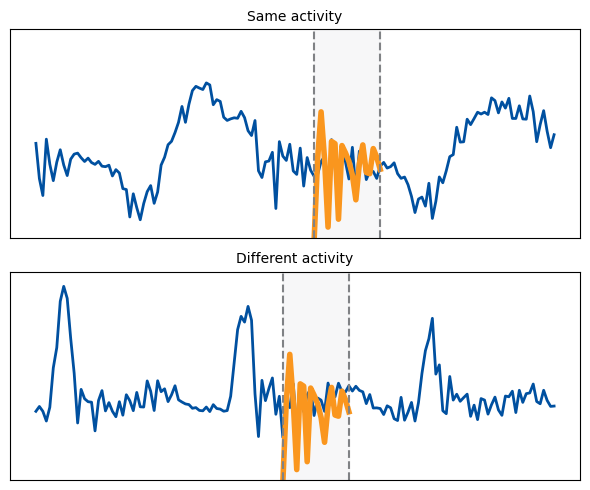

In [13]:
# Create the figure and the 2 subplots (2 rows, 1 column)
fig, axs = plt.subplots(2, 1, figsize=(6, 5))

# Plot the same from the same activity and the shapelet in the first subplot
axs[0].plot(same_sample, label="Time Series", color=scale_rgb(COLOURS.get("primary-color")), linewidth=2)
axs[0].plot(range(same_activity_sample_start_index, same_activity_sample_start_index + 20), shapelet, 
            label="Shapelet", color = scale_rgb(COLOURS.get("accent-orange")), linewidth=4)
axs[0].set_title('Same activity', fontsize=10)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].axvline(x=same_activity_sample_start_index, color = scale_rgb(COLOURS.get("accent-grey-dark-2")), linestyle='--', linewidth=1.5)
axs[0].axvline(x=same_activity_sample_start_index + 20 - 1, color = scale_rgb(COLOURS.get("accent-grey-dark-2")), linestyle='--', linewidth=1.5)
axs[0].axvspan(same_activity_sample_start_index, same_activity_sample_start_index + 20 - 1, color=scale_rgb(COLOURS.get("accent-grey-light-1")), alpha=0.3)
axs[0].set_ylim([-1.5, 0.5])

# Plot the sample from the different activity and the shapelet in the second subplot
axs[1].plot(diff_sample, label="Time Series", color=scale_rgb(COLOURS.get("primary-color")), linewidth=2)
axs[1].plot(range(diff_activity_sample_start_index, diff_activity_sample_start_index + 20), shapelet, 
            label="Shapelet", color=scale_rgb(COLOURS.get("accent-orange")), linewidth=4)
axs[1].set_title('Different activity', fontsize=10)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].axvline(x=diff_activity_sample_start_index, color = scale_rgb(COLOURS.get("accent-grey-dark-2")), linestyle='--', linewidth=1.5)
axs[1].axvline(x=diff_activity_sample_start_index + 20 - 1, color = scale_rgb(COLOURS.get("accent-grey-dark-2")), linestyle='--', linewidth=1.5)
axs[1].axvspan(diff_activity_sample_start_index, diff_activity_sample_start_index + 20 - 1, color=scale_rgb(COLOURS.get("accent-grey-light-1")), alpha=0.3)
axs[1].set_ylim([-1.5, 0.5])

# Adjust the layout to prevent overlapping titles and labels
plt.tight_layout()
plt.savefig('ShapeletOverlay.pdf', dpi = 1000, format = 'pdf', bbox_inches = 'tight')
plt.show()